In [241]:
import shap
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [242]:
with open("../T23_shap_ml/S01_shap_calc.pkl", "rb") as f:
    data = pickle.load(f)
    shaps_ml = data["shaps"]
    infos_ml = data["infos"]

In [243]:
pd.DataFrame.from_dict(infos_ml)

,model,model_params,test_size,random_state
0,DTR,"{'criterion': 'squared_error', 'splitter': 'ra...",0.3,4
1,EN,"{'alpha': 0.03388469103413104, 'l1_ratio': 0.4...",0.3,5
2,GBR,"{'n_estimators': 134, 'learning_rate': 0.02748...",0.3,4
3,KNR,"{'n_neighbors': 36, 'weights': 'distance', 'al...",0.3,5
4,RFR,"{'n_estimators': 60, 'max_depth': 5, 'min_samp...",0.3,5
5,SVR,"{'kernel': 'linear', 'C': 0.012708183589980318...",0.3,5
6,XGBR,"{'n_estimators': 229, 'max_depth': 8, 'learnin...",0.3,5


In [244]:
shap_values_list = []

In [245]:
idxs = [1, 2, 4, 6]
for idx in idxs:
    shap_values = shaps_ml[idx]["shap_values"]
    model = shaps_ml[idx]["model"]
    shap_values_list.append(shap_values)
    print(f"Model: {model}")

Model: EN
Model: GBR
Model: RFR
Model: XGBR


In [246]:
with open("../T24_shap_tabPFN/S02_shap_values.pkl", "rb") as f:
    data = pickle.load(f)
    shaps_tabPFN = data["shaps"]


shap_values_list.append(shaps_tabPFN)

In [247]:
# Combine SHAP values
feature_names = shap_values_list[0].feature_names

# Combine values
combined_shape_values = np.vstack([sv.values for sv in shap_values_list])
combined_shape_values.shape

# Combine base values
combined_base_values = np.concatenate([sv.base_values for sv in shap_values_list])
combined_base_values.shape

# Combine data (feature values)
combined_data = np.vstack([sv.data for sv in shap_values_list])
combined_data.shape

(1554, 20)

In [248]:
shap_values = shap.Explanation(
    values=combined_shape_values, 
    base_values=combined_base_values,
    data=combined_data,
    feature_names=feature_names,
)

In [249]:
def extract_features(val):
    match1 = re.match(r"^(Fx|Fy|Fz|Mz)__(dwell|weld)", val)    
    measure = val
    phase = val
    feature_name_grouped = val
    if match1:   
        sp = match1.group(0).split("__")
        measure = sp[0]
        phase = sp[1]
        feature_name_grouped = f"{measure}_{phase}"
    return measure, phase, feature_name_grouped
    
        
feat = pd.DataFrame(feature_names, columns=["feature_name"])
feat["measure"], feat["phase"], feat["feature_name_grouped"] = zip(*feat["feature_name"].apply(extract_features))
feat

,feature_name,measure,phase,feature_name_grouped
0,D,D,D,D
1,Fx__dwell__ar_coefficient__coeff_0__k_10,Fx,dwell,Fx_dwell
2,"Fx__dwell__fft_coefficient__attr_""abs""__coeff_11",Fx,dwell,Fx_dwell
3,"Fx__weld__change_quantiles__f_agg_""var""__isabs...",Fx,weld,Fx_weld
4,"Fx__weld__fft_coefficient__attr_""abs""__coeff_5",Fx,weld,Fx_weld
5,Fx_location,Fx_location,Fx_location,Fx_location
6,"Fy__dwell__fft_coefficient__attr_""abs""__coeff_59",Fy,dwell,Fy_dwell
7,"Fy__dwell__fft_coefficient__attr_""real""__coeff_71",Fy,dwell,Fy_dwell
8,"Fy__weld__change_quantiles__f_agg_""mean""__isab...",Fy,weld,Fy_weld
9,Fy__weld__energy_ratio_by_chunks__num_segments...,Fy,weld,Fy_weld


In [250]:
# Group SHAP values by measure_phase
cbsv = pd.DataFrame(combined_shape_values, columns=feat["feature_name_grouped"])
cbsv = cbsv.T.groupby(by="feature_name_grouped").sum().T
display(cbsv)

feature_name_grouped,D,Fx_dwell,Fx_location,Fx_weld,Fy_dwell,Fy_weld,Fz_dwell,Fz_location,Fz_weld,Mz_dwell,R,W,position
0,-0.004788,-0.024171,0.083762,0.034507,0.054640,-0.197967,0.008570,0.029131,0.180290,-0.003140,-0.199300,-0.150801,-0.746807
1,-0.004788,-0.024171,-0.186362,0.034507,0.054640,-0.197967,0.008570,-0.167984,0.180290,-0.003140,-0.199300,-0.150801,0.865007
2,-0.004788,0.022293,0.083172,0.031798,0.003864,0.202014,0.019834,0.026855,0.031706,-0.003140,-0.199300,0.006283,0.059100
3,-0.124499,0.019327,-0.016495,-0.026159,0.040826,0.108930,0.033564,-0.012643,-0.054339,-0.001330,-0.199300,-0.150801,0.596371
4,-0.124499,-0.025710,-0.025643,0.068541,-0.013288,-0.017516,0.051936,-0.033852,-0.022368,-0.003141,0.207435,-0.150801,0.596371
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1549,0.026431,0.034868,0.033097,-0.009008,0.068338,-0.041963,-0.013619,-0.034194,0.010152,-0.020166,-0.225549,0.074641,-0.730626
1550,0.039682,0.011130,0.017026,-0.027369,0.028531,0.004854,0.025479,-0.004269,0.007599,0.001006,-0.417073,0.098936,0.273104
1551,0.031988,0.112701,0.027431,-0.024121,0.193033,0.032008,-0.002534,0.014709,0.034139,0.014169,-0.224065,0.135923,0.392642
1552,0.050165,0.013252,-0.021283,-0.035188,0.004990,-0.006186,-0.069651,0.016352,-0.001814,0.009642,-0.247422,0.044635,0.231385


In [251]:
cbdt = pd.DataFrame(combined_data, columns=feat["feature_name_grouped"])
cbdt = cbdt.T.groupby(by="feature_name_grouped").mean().T
display(cbdt)

feature_name_grouped,D,Fx_dwell,Fx_location,Fx_weld,Fy_dwell,Fy_weld,Fz_dwell,Fz_location,Fz_weld,Mz_dwell,R,W,position
0,0.023403,0.427690,0.736407,0.330315,-0.616574,0.863326,-0.018938,0.460581,1.467101,-0.603731,1.248345,-1.224745,1.518433
1,0.023403,0.427690,-1.448297,0.330315,-0.616574,0.863326,-0.018938,-1.944154,1.467101,-0.603731,1.248345,-1.224745,-1.491827
2,0.023403,-0.348473,0.731641,-0.277588,-0.262739,-1.097640,-0.373011,0.432817,0.364472,-0.704606,1.248345,0.000000,0.013303
3,-1.212254,-0.316794,-0.074444,-0.609776,-0.338959,-0.980444,-0.394129,-0.049047,0.503720,0.201287,1.248345,-1.224745,-0.990117
4,-1.212254,0.316493,-0.148432,0.996420,0.382194,0.067278,-0.199024,-0.307792,0.090825,-0.844258,-1.229573,-1.224745,-0.990117
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1549,1.277347,0.041051,0.568181,-0.513054,-1.232463,0.955368,-0.191240,1.524944,-0.491109,-1.535566,-0.050953,0.036930,1.012931
1550,1.277347,0.184558,0.114845,0.440236,-0.458330,0.965039,0.099258,-0.397477,-0.106969,-0.324545,1.171912,1.255605,0.020672
1551,0.037569,-1.332547,-0.009964,-0.436240,-0.713594,-0.895881,-0.081969,-0.392532,-0.502177,-0.201957,-0.050953,1.255605,-0.971587
1552,1.277347,-0.176845,-0.300550,-1.596604,-0.035799,-0.652856,-1.227005,-0.085165,-0.124157,0.481560,-0.050953,-1.181745,-1.467716


In [252]:
shap_values_grouped = shap.Explanation(
    values=cbsv.values, 
    base_values=combined_base_values, # unchanged
    data=cbdt.values,
    feature_names=cbsv.columns.tolist(),
)

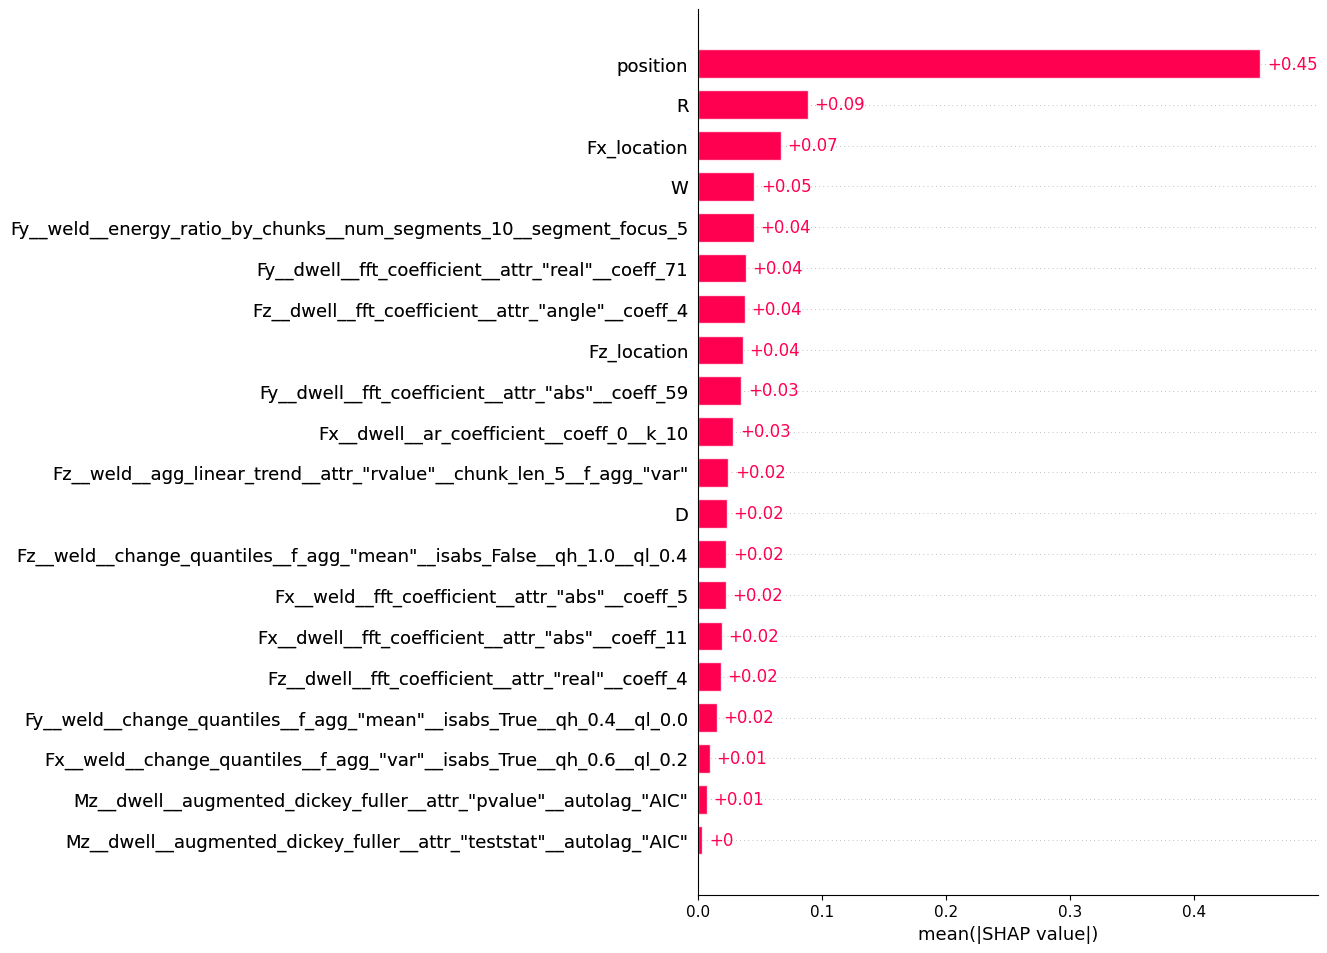

In [253]:
shap.plots.bar(shap_values, max_display=20)

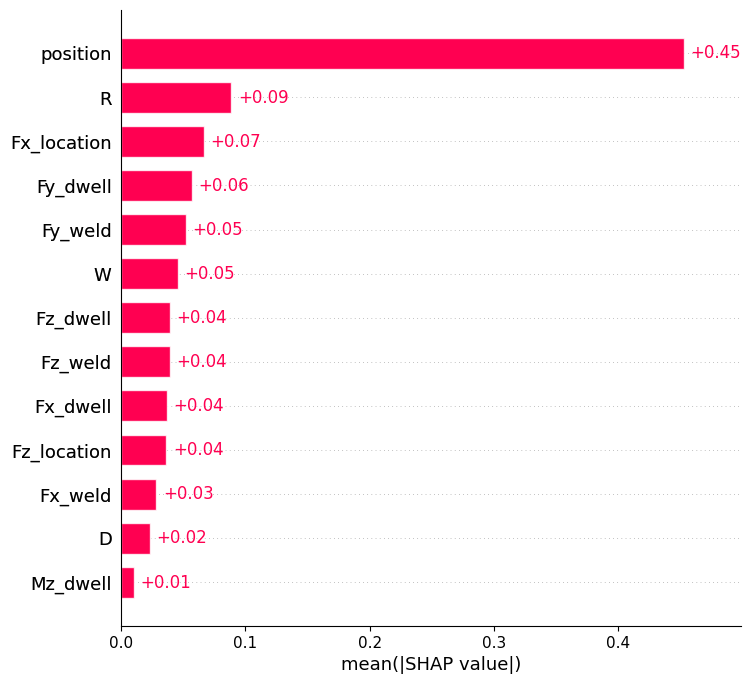

In [254]:
shap.plots.bar(shap_values_grouped, max_display=20)

In [255]:
shap_values_grouped.feature_names

['D',
 'Fx_dwell',
 'Fx_location',
 'Fx_weld',
 'Fy_dwell',
 'Fy_weld',
 'Fz_dwell',
 'Fz_location',
 'Fz_weld',
 'Mz_dwell',
 'R',
 'W',
 'position']

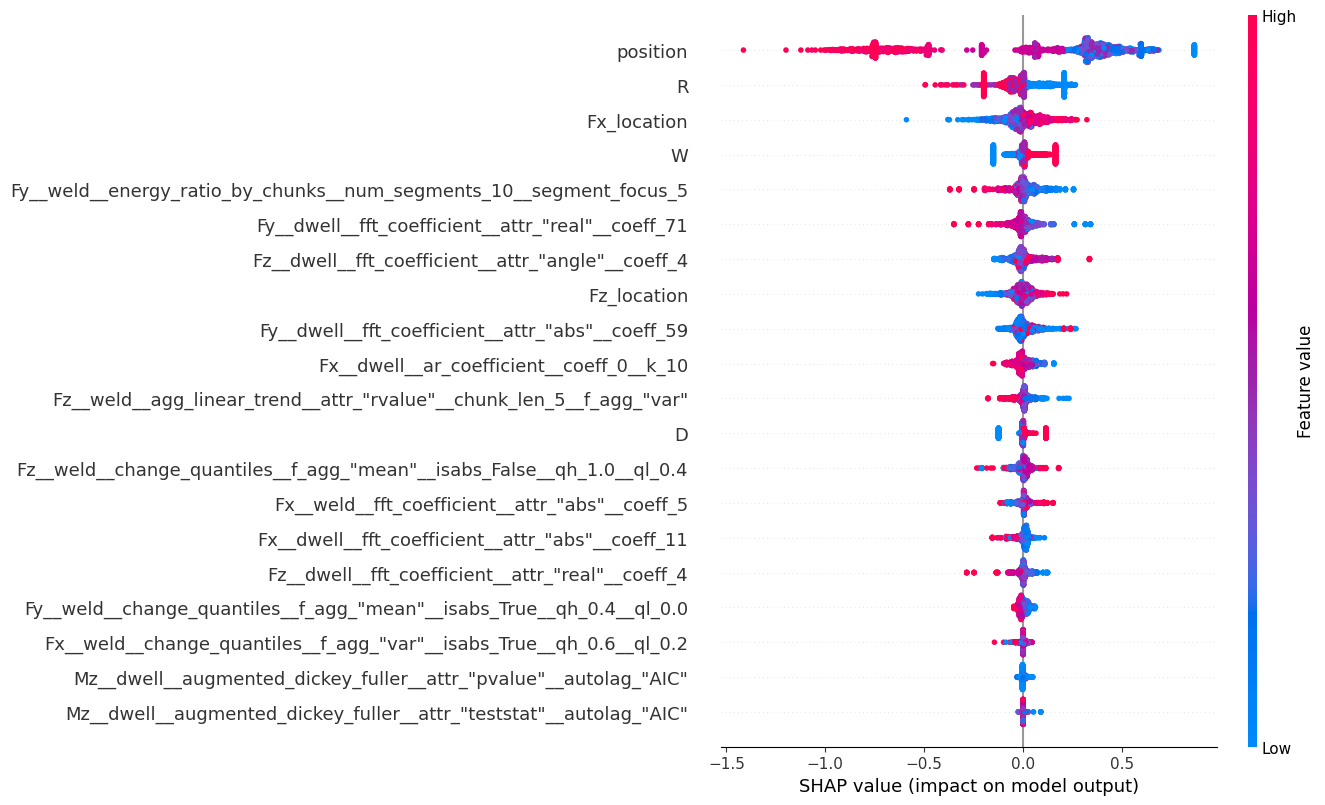

In [256]:
shap.plots.beeswarm(shap_values, max_display=20)

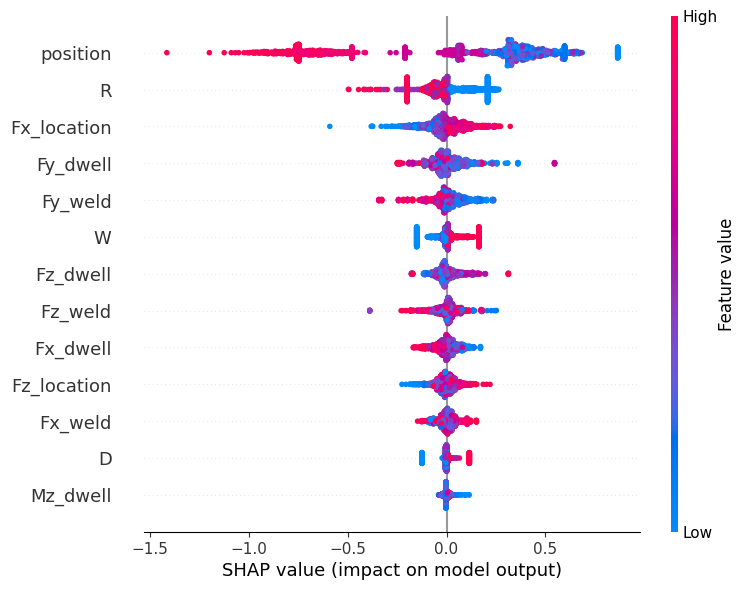

In [257]:
shap.plots.beeswarm(shap_values_grouped, max_display=20)

Text(0.5, 1.0, 'SHAP Value Distribution by Feature (Grouped)')

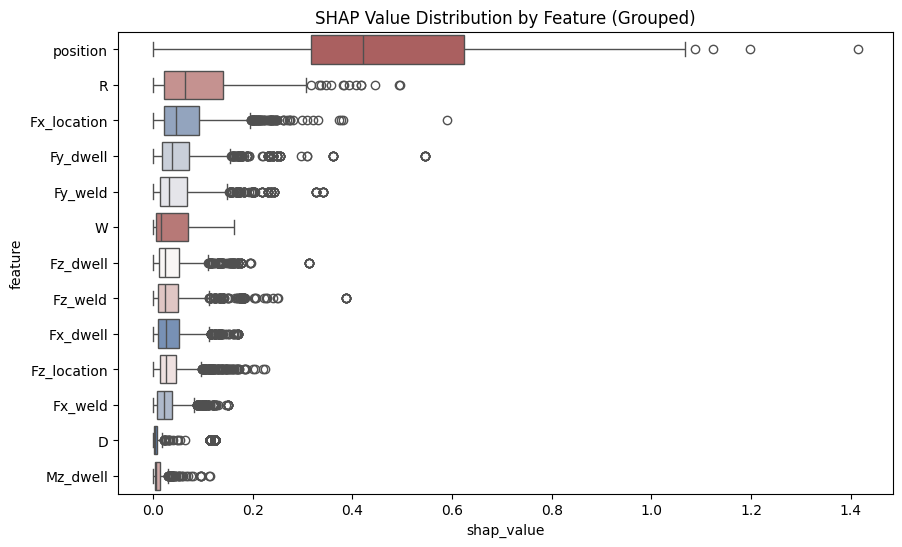

In [269]:
import seaborn as sns

df_shap = pd.DataFrame(shap_values_grouped.values, columns=shap_values_grouped.feature_names)
df_shap_melt = df_shap.melt(var_name="feature", value_name="shap_value")
df_shap_melt_mag = df_shap_melt.copy()
df_shap_melt_mag["shap_value"] = df_shap_melt_mag["shap_value"].abs()
# boxplot
df_plot = df_shap_melt_mag
# sort = df_plot.groupby("feature")["shap_value"].median().sort_values(ascending=False).index
sort = df_plot.groupby("feature")["shap_value"].mean().sort_values(ascending=False).index
plt.figure(figsize=(10, 6))
sns.boxplot(x="shap_value", y="feature", data=df_plot, order=sort, palette="vlag", hue="feature")
plt.title("SHAP Value Distribution by Feature (Grouped)")